In [51]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline
import tensorflow as tf
import keras
import glob
import cv2
import pickle, datetime

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import LSTM, Input, TimeDistributed,Convolution2D,Activation
from keras.layers.convolutional import ZeroPadding2D
from keras.optimizers import RMSprop, SGD
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing import sequence
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Import the backend
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import os

In [52]:
train_cotton_images = []
train_cotton_labels = [] 
for directory_path in glob.glob("D:/COTTONDATASET/Train/*"):
    cotton_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (227, 227))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_cotton_images.append(img)
        train_cotton_labels.append(cotton_label)
train_cotton_images = np.array(train_cotton_images)
train_cotton_labels = np.array(train_cotton_labels)

In [53]:
train_cotton_labels
    

array(['Absent', 'Absent', 'Absent', ..., 'present', 'present', 'present'],
      dtype='<U7')

In [54]:
label_to_id = {v:i for i,v in enumerate(np.unique(train_cotton_labels))}
id_to_label = {v:k for k, v in label_to_id.items()}
train_label_ids = np.array([label_to_id[x] for x in train_cotton_labels])

In [55]:
train_cotton_images.shape, train_label_ids.shape, train_cotton_labels.shape

((1746, 227, 227, 3), (1746,), (1746,))

In [56]:
test_cotton_images = []
test_cotton_labels = [] 

for directory_path in glob.glob("D:/COTTONDATASET/Test/*"):
    cotton_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (227, 227))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_cotton_images.append(img)
        test_cotton_labels.append(cotton_label)
test_cotton_images = np.array(test_cotton_images)
test_cotton_labels = np.array(test_cotton_labels)

In [57]:
test_cotton_labels


array(['Absent', 'Absent', 'Absent', 'Absent', 'Absent', 'Absent',
       'Absent', 'Absent', 'Absent', 'Absent', 'Absent', 'Absent',
       'Absent', 'Absent', 'Absent', 'Absent', 'Absent', 'Absent',
       'Absent', 'Absent', 'Absent', 'Absent', 'Absent', 'Absent',
       'Absent', 'Absent', 'Absent', 'Absent', 'Absent', 'Absent',
       'Absent', 'Absent', 'Absent', 'Absent', 'Absent', 'Absent',
       'Absent', 'Absent', 'Absent', 'Absent', 'Absent', 'Absent',
       'Absent', 'Absent', 'Absent', 'Absent', 'Absent', 'Absent',
       'Absent', 'Absent', 'Absent', 'Absent', 'Absent', 'Absent',
       'Absent', 'Absent', 'Absent', 'Absent', 'Absent', 'Absent',
       'Absent', 'Absent', 'Absent', 'Absent', 'Absent', 'Absent',
       'present', 'present', 'present', 'present', 'present', 'present',
       'present', 'present', 'present', 'present', 'present', 'present',
       'present', 'present', 'present', 'present', 'present', 'present',
       'present', 'present', 'present', 'pre

In [58]:
test_label_to_id = {v:i for i,v in enumerate(np.unique(test_cotton_labels))}
test_label_ids = np.array([test_label_to_id[x] for x in test_cotton_labels])

In [59]:
test_cotton_images.shape, test_label_ids.shape

((153, 227, 227, 3), (153,))

In [60]:
x_train, y_train, x_test, y_test, N_CATEGORY =train_cotton_images,train_cotton_labels,test_cotton_images,test_cotton_labels,len(label_to_id)


print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, N_CATEGORY)

(1746, 227, 227, 3) (1746,) (153, 227, 227, 3) (153,) 2


In [61]:
def get_alexnet(input_shape,nb_classes): 
    model = Sequential() 
    # Layer 1 
    model.add(Convolution2D(96, 11, 11, input_shape = input_shape, border_mode='same')) 
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    # Layer 2 
    model.add(Convolution2D(128, 5, 5, border_mode='same')) 
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2)) 
    # Layer 3 
    model.add(ZeroPadding2D((1,1))) 
    model.add(Convolution2D(384, 3, 3, border_mode='same')) 
    model.add(Activation('relu')) 
    # Layer 4 
    model.add(ZeroPadding2D((1,1))) 
    model.add(Convolution2D(192, 3, 3, border_mode='same')) 
    model.add(Activation('relu')) 
    # Layer 5 
    model.add(ZeroPadding2D((1,1))) 
    model.add(Convolution2D(128, 3, 3, border_mode='same')) 
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2))) 
    # Layer 6 
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(4096, init='glorot_normal')) 
    model.add(Activation('relu')) 
    model.add(Dropout(0.5)) 
    # Layer 7 
    model.add(Dense(4096, init='glorot_normal')) 
    model.add(Activation('tanh')) 
    model.add(Dropout(0.5)) 
    # Layer 8 
    model.add(Dense(nb_classes, init='glorot_normal')) 
    model.add(Activation('tanh')) 
    return model 

In [62]:
alexnet = get_alexnet((227,227,3),N_CATEGORY)
alexnet.summary()

c:\users\mihir\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (11, 11), input_shape=(227, 227,..., padding="same")`
  after removing the cwd from sys.path.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 227, 227, 96)      34944     
_________________________________________________________________
activation_9 (Activation)    (None, 227, 227, 96)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 113, 113, 96)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 113, 113, 128)     307328    
_________________________________________________________________
activation_10 (Activation)   (None, 113, 113, 128)     0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 58, 58, 128)       0         
__________

c:\users\mihir\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), padding="same")`
  
c:\users\mihir\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(384, (3, 3), padding="same")`
  del sys.path[0]
c:\users\mihir\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), padding="same")`
c:\users\mihir\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
c:\users\mihir\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4096, kernel_initializer="glorot_norm

In [63]:
#Normalization of the images and one-hot encoding of the labels
alexnet.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(),metrics=['accuracy'])
X_normalized = np.array(x_train / 255.0 - 0.5 )
X_normalized_test = np.array(x_test / 255.0 - 0.5 )

label_binarizer = LabelBinarizer()
y_one_hot = label_binarizer.fit_transform(y_train)
y_one_hot_test = label_binarizer.fit_transform(y_test)

In [64]:
#Training the AlexNet model with the normalized image data and labels
alexnet.fit(X_normalized, y_one_hot, batch_size=5, epochs=2,verbose=1, validation_data=[X_normalized_test,y_one_hot_test])

Train on 1746 samples, validate on 153 samples
Epoch 1/2
1746/1746 [==============================] - 2061s 1s/step - loss: 0.7075 - acc: 0.6019 - val_loss: 0.6931 - val_acc: 0.4314
Epoch 2/2
1746/1746 [==============================] - 2061s 1s/step - loss: 0.6931 - acc: 0.6019 - val_loss: 0.6931 - val_acc: 0.4314


In [66]:
alexnet.save('alexnetcottoncnnrf.h5')

layer_name = 'dense_1'
FC_layer_model = Model(inputs=alexnet.input,
                                 outputs=alexnet.get_layer(layer_name).output)

In [68]:
#Find the Features for n number of train images and we will get n x 4096
#This means we will get 4096 features for each images.
i=0
features=np.zeros(shape=(x_train.shape[0],4096))
for directory_path in glob.glob("D:/COTTONDATASET/Train/*"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
        img = cv2.resize(img, (227, 227))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = np.expand_dims(img, axis=0)
        FC_output = FC_layer_model.predict(img)
        features[i]=FC_output
        i+=1

In [69]:
#Save the features of the train images to use it in future.
np.save('features', features)

In [70]:
#Name the feature rows as f_0, f_1, f_2...
feature_col=[]
for i in range(4096):
    feature_col.append("f_"+str(i))
    i+=1

In [71]:
#Create DataFrame with features and coloumn name
train_features=pd.DataFrame(data=features,columns=feature_col)
feature_col = np.array(feature_col)

train_class = list(np.unique(train_label_ids))
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_label_ids.shape)
train_class

Training Features Shape: (1746, 4096)
Training Labels Shape: (1746,)


[0, 1]

In [72]:
#Feed the extracted features with the labels to RANDOM FOREST 
rf = RandomForestClassifier(n_estimators = 20, random_state = 42,max_features=4)

rf.fit(train_features, train_label_ids)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [73]:
#Find the Features from Alexnet's FC layer for n number of test images and we will get n x 4096
i=0
features_test=np.zeros(shape=(y_test.shape[0],4096))
for directory_path in glob.glob("D:/COTTONDATASET/Test/*"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
        img = cv2.resize(img, (227, 227))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = np.expand_dims(img, axis=0)
        FC_output = FC_layer_model.predict(img)
        features_test[i]=FC_output
        i+=1

In [74]:
#Create DataFrame with features and coloumn name
test_features=pd.DataFrame(data=features_test,columns=feature_col)
feature_col = np.array(feature_col)

print('Test Features Shape:', test_features.shape)
print('Test Labels Shape:', test_label_ids.shape)

Test Features Shape: (153, 4096)
Test Labels Shape: (153,)


In [75]:
#Feed the features of the test images to Random Forest Classifier to predict its class
predictions = rf.predict(test_features)

In [76]:
accuracy=accuracy_score(predictions , test_label_ids)
print('Accuracy:', accuracy*100, '%.')

Accuracy: 89.54248366013073 %.


It's Absent


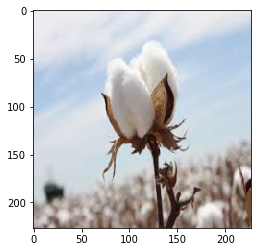

In [77]:
img_path="D://COTTONDATASET//cotton.png"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.resize(img, (227, 227))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
FC_output = FC_layer_model.predict(img)
image_features=pd.DataFrame(data=FC_output,columns=feature_col)
predictions = rf.predict(image_features)
print("It's",id_to_label[predictions[0]])

It's present


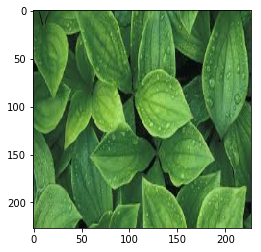

In [78]:
img_path="D://COTTONDATASET//leaves.png"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.resize(img, (227, 227))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
FC_output = FC_layer_model.predict(img)
image_features=pd.DataFrame(data=FC_output,columns=feature_col)
predictions = rf.predict(image_features)
print("It's",id_to_label[predictions[0]])

It's present


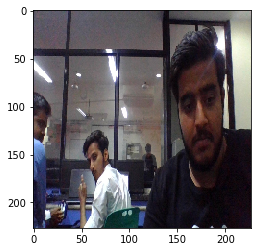

In [80]:
img_path="D://COTTONDATASET//notcotton.jpg"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.resize(img, (227, 227))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
FC_output = FC_layer_model.predict(img)
image_features=pd.DataFrame(data=FC_output,columns=feature_col)
predictions = rf.predict(image_features)
print("It's",id_to_label[predictions[0]])

In [81]:
id_to_label

{0: 'Absent', 1: 'present'}

It's present


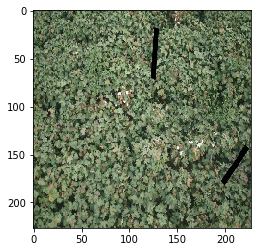

In [83]:
img_path="D://COTTONDATASET//Test//Absent//24.jpg"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.resize(img, (227, 227))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
FC_output = FC_layer_model.predict(img)
image_features=pd.DataFrame(data=FC_output,columns=feature_col)
predictions = rf.predict(image_features)
print("It's",id_to_label[predictions[0]])

It's Absent


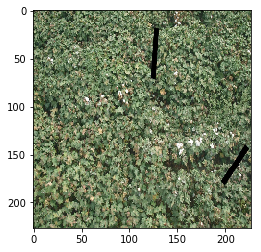

In [84]:
img_path="D://COTTONDATASET//Test//Absent//38.jpg"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.resize(img, (227, 227))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
FC_output = FC_layer_model.predict(img)
image_features=pd.DataFrame(data=FC_output,columns=feature_col)
predictions = rf.predict(image_features)
print("It's",id_to_label[predictions[0]])

It's present


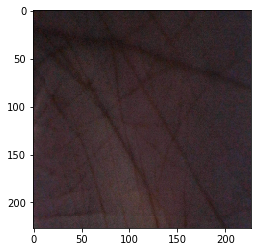

In [85]:
img_path="D://COTTONDATASET//hand.jpg"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.resize(img, (227, 227))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
FC_output = FC_layer_model.predict(img)
image_features=pd.DataFrame(data=FC_output,columns=feature_col)
predictions = rf.predict(image_features)
print("It's",id_to_label[predictions[0]])

It's present


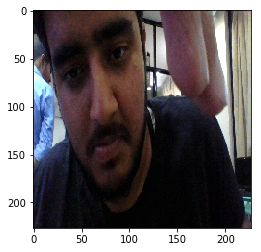

In [86]:
img_path="D://COTTONDATASET//not_cotton.jpg"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.resize(img, (227, 227))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
FC_output = FC_layer_model.predict(img)
image_features=pd.DataFrame(data=FC_output,columns=feature_col)
predictions = rf.predict(image_features)
print("It's",id_to_label[predictions[0]])